# Construcción de Portafolios de Inversión

    - Se va a construir un Portafolio de Inversión con el método CAPM para acciones inscritas en la BMV
    - Se tomará como referencia el índice IPC y se intentará superar el rendimiento año con año
    - El análisis tendrá como base el comportamiento histórico de 2010 - 2019 (10 años)
    - Se probará el comportamiento del Portafolio para 2020, 2021, 2022, 2023 y 2024

In [1]:
# Librerías
import pandas as pd
import yfinance as yf
import investpy as inv
import holidays
from datetime import date
from pylab import mpl, plt
import scipy.optimize as sco

from Functions import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Activar Modo Obscuro para gráficos
fn_DarkMode()

# Variables Iniciales
Country = "mexico"
Benchmarck = "^MXX"
Year_Start_Train, Year_End_Train, Year_Start_Test, Year_End_Test = 2010, 2019, 2020, 2020

Date_Start_Train, Date_End_Train, Date_Start_Test, Date_End_Test = fnGetDay(Year_Start_Train, "First"), fnGetDay(Year_End_Train, "Last"), fnGetDay(Year_Start_Test, "First"), fnGetDay(Year_End_Test, "Last")

In [3]:
# Definición del Benchmarck sobre el IPC
Price_Start = round(fnGetPrice(Benchmarck, Date_Start_Train), 4)
Price_End = round(fnGetPrice(Benchmarck, Date_End_Train), 4)
Return_Benchmarck = round(Price_End / Price_Start * 100 - 100, 2)

print(f"Benchmarck {Return_Benchmarck} % del periodo {Year_Start_Train} - {Year_End_Train}")
print(f"El Precio Inicial es {Price_Start}, el Precio Final es {Price_End}")

Benchmarck 32.92 % del periodo 2010 - 2019
El Precio Inicial es 32758.5293, el Precio Final es 43541.0195


In [4]:
# Selección de Activos con buen Rendimiento en los 10 años previos
df_Stocks = pd.read_csv("MexicanStocks10Years.csv")
df_Stocks["Return"] = df_Stocks["Price_End"] / df_Stocks["Price_Start"] - 1
df_Stocks = df_Stocks.sort_values(by = "Return", ascending = False)
df_Stocks = df_Stocks.drop("Unnamed: 0", axis = 1)

df_Stocks = df_Stocks[df_Stocks["Return"] >= 1]
df_Stocks = df_Stocks.head(10)
df_Stocks

,Symbol,Price_Start,Price_End,Return
88,RASSINIA.MX,1.0261,41.5000,39.444401
116,AMZN.MX,48.9465,1750.9495,34.772721
180,BKNG.MX,1390.0730,38869.1758,26.961967
195,UAL.MX,73.0100,1715.0000,22.489933
207,STZ.MX,154.2109,3564.4250,22.113963
115,AAPL.MX,97.5545,1376.4250,13.109293
95,VALUEGFO.MX,9.0224,125.0000,12.854407
197,V.MX,278.2054,3537.2209,11.714422
206,SPGI.MX,416.3734,5129.6895,11.319926
138,GISSAA.MX,1.4354,17.3334,11.075658


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed


<Axes: xlabel='Date'>

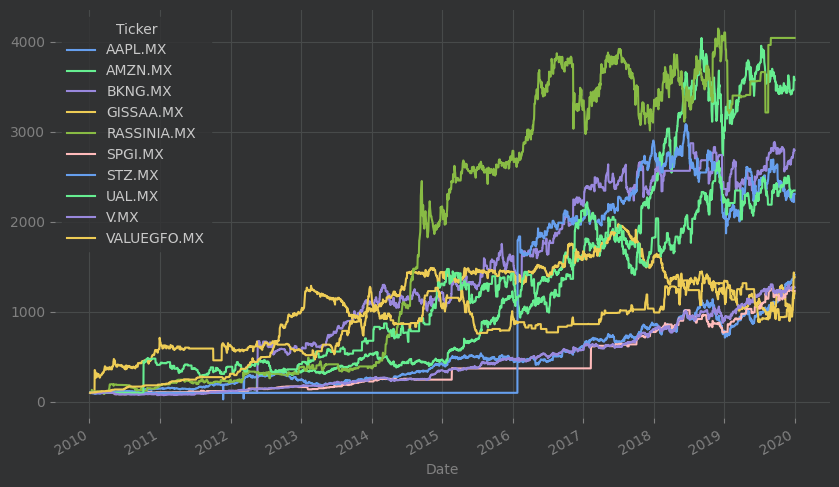

In [5]:
# Dataframe completo con los Stocks seleccionados
Symbols = df_Stocks["Symbol"].to_list()
Total_Rows = len(Symbols)
df_Returns = yf.download(Symbols, start = "2010-01-01", end = "2019-12-31")
df_Returns = df_Returns['Adj Close']
df_Returns = df_Returns.dropna()
Returns = np.log(df_Returns / df_Returns.shift(1))

# Dataframe con los Stocks Top 10 seleccionados
Symbols_Top = df_Stocks["Symbol"].head(10).to_list()
df_Returns_Top = yf.download(Symbols_Top, start = "2010-01-01", end = "2019-12-31")
df_Returns_Top = df_Returns_Top['Adj Close']
df_Returns_Top = df_Returns_Top.dropna()

(df_Returns_Top / df_Returns_Top.iloc[0] * 100).plot(figsize = (10, 6))

In [6]:
# Mostrar la Media Anualizada de los Retornos de cada activo
Returns.mean() * 252

Ticker
AAPL.MX        0.266481
AMZN.MX        0.360148
BKNG.MX        0.335347
GISSAA.MX      0.250810
RASSINIA.MX    0.372504
SPGI.MX        0.252827
STZ.MX         0.316177
UAL.MX         0.317801
V.MX           0.256001
VALUEGFO.MX    0.264646
dtype: float64

In [7]:
# Mostrar la Matriz de Covarianza Anualizada de los Retornos de cada activo
Returns.cov() * 252

Ticker,AAPL.MX,AMZN.MX,BKNG.MX,GISSAA.MX,RASSINIA.MX,SPGI.MX,STZ.MX,UAL.MX,V.MX,VALUEGFO.MX
Ticker,,,,,,,,,,
AAPL.MX,1.594949,0.016226,0.016282,-0.001800,0.064167,0.001883,-0.000679,0.005908,0.018184,0.006306
AMZN.MX,0.016226,0.191731,0.011170,0.008488,0.001848,0.003681,0.000663,0.008088,0.017986,0.001359
BKNG.MX,0.016282,0.011170,0.410359,-0.001236,-0.004712,0.003223,0.002148,-0.002455,0.006336,0.004128
GISSAA.MX,-0.001800,0.008488,-0.001236,0.248891,0.005015,-0.001657,0.000359,0.003691,0.001657,0.000720
RASSINIA.MX,0.064167,0.001848,-0.004712,0.005015,0.169276,-0.000450,-0.001695,-0.003902,-0.001700,0.003753
SPGI.MX,0.001883,0.003681,0.003223,-0.001657,-0.000450,0.078732,0.001969,0.001503,0.001046,0.001408
STZ.MX,-0.000679,0.000663,0.002148,0.000359,-0.001695,0.001969,0.858717,-0.000821,-0.000370,-0.000599
UAL.MX,0.005908,0.008088,-0.002455,0.003691,-0.003902,0.001503,-0.000821,0.365203,0.005269,0.005111
V.MX,0.018184,0.017986,0.006336,0.001657,-0.001700,0.001046,-0.000370,0.005269,0.049154,0.001069


In [8]:
# Cálculo de los Pesos del Portafolio aleatoriamente con Distribución Uniforme
Weights_Portfolio = np.random.random(Total_Rows) # Pesos del portafolio aleatorios (generados con Distribución Uniforme)
Weights_Portfolio /= np.sum(Weights_Portfolio)      # Normalizados de 1 a 100
print("Pesos: " + str(Weights_Portfolio) + " Total: " + str(Weights_Portfolio.sum()))

Pesos: [0.10402256 0.03624948 0.1824684  0.04186706 0.23917051 0.24319506
 0.08191904 0.05251973 0.01540881 0.00317935] Total: 1.0


In [9]:
# Calcular la Rentabilidad del Portafolio con los Pesos obtenidos previamente
Portfolio_Return = np.sum(Returns.mean() * Weights_Portfolio) * 252
print("Rentabilidad Esperada Anualizada de la Cartera: " + str(Portfolio_Return))

Rentabilidad Esperada Anualizada de la Cartera: 0.31042219505828655


In [10]:
# En Python:
Portfolio_Var = np.dot(Weights_Portfolio.T, np.dot(Returns.cov() * 252, Weights_Portfolio)) # Varianza Anualizada del Portafolio
Portfolio_Vol = np.sqrt(np.dot(Weights_Portfolio.T, np.dot(Returns.cov() * 252, Weights_Portfolio)))  # Volatilidad Anualizada del Portafolio
print("Varianza Anualizada del Portafolio: " + str(Portfolio_Var) + " Volatilidad Anualizada del Portafolio: " + str(Portfolio_Vol))

Varianza Anualizada del Portafolio: 0.05709159450820288 Volatilidad Anualizada del Portafolio: 0.23893847431546658


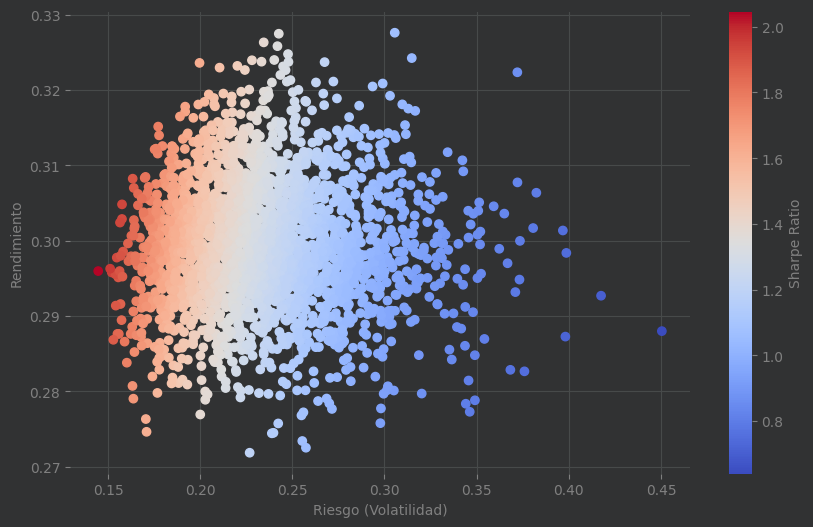

In [11]:
PRets = []
PVols = []

for p in range (2500):                                      # Simulación Monte Carlo para encontrar los pesos del Portafolio
    Weights = np.random.random(Total_Rows)                  # Simulación Monte Carlo para encontrar los pesos del Portafolio
    Weights /= np.sum(Weights)                              # Simulación Monte Carlo para encontrar los pesos del Portafolio
    PRets.append(fnPortfolioReturn(Weights, Returns))       # Obtener los datos estadísticos del Portafolio
    PVols.append(fnPortfolioVolatility(Weights, Returns))   # Obtener los datos estadísticos del Portafolio
PRets = np.array(PRets)
PVols = np.array(PVols)

plt.figure(figsize = (10, 6))
plt.scatter(PVols, PRets, c = PRets / PVols, marker = 'o', cmap = 'coolwarm')
plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Rendimiento')
plt.colorbar(label = 'Sharpe Ratio')

In [14]:
# Encontrar el Portafolio Óptimo
Cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # Restriccoión de Igualdad
Bands = tuple((0, 1) for x in range(Total_Rows)) # Límites para los parámetros

EWeights = np.array(Total_Rows * [1. / Total_Rows,]) # Vector de Pesos Iguales

fnMinFuncSharpe(EWeights, Returns)

-1.4197200532892624

In [16]:
# Función de Optimización (Sharpe Ratio) con el método SLSQP (Optimizador de Programación de Mínimos Cuadrados Secuenciales)
opts = sco.minimize(fnMinFuncSharpe(EWeights, Returns), EWeights, method = 'SLSQP', bounds = Bands, constraints = Cons)
opts # Resultados de Optimización

TypeError: 'numpy.float64' object is not callable